In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict

In [2]:
import sys
sys.path.append('../')

from myutils.metrics import mapk

In [3]:
train_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_log.csv')
train_df = pd.read_csv('../datasets/atmaCup16_Dataset/train_label.csv')
test_log_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_log.csv')
yado_df = pd.read_csv('../datasets/atmaCup16_Dataset/yado.csv')

train_session_only_df = train_df[['session_id']]
test_session_only_df = pd.read_csv('../datasets/atmaCup16_Dataset/test_session.csv')

In [4]:
train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [5]:
# train_test_session_df = train_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()
train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

In [6]:
from collections import Counter

next_item_dict = defaultdict(list)
for yads in train_test_session_df['yad_no'].values:
    if len(yads) == 1:
        continue
    for i in range(len(yads)-1):
        next_item_dict[yads[i]].append(yads[i+1])

        next_item_dict[yads[i+1]].append(yads[i])

results = []
for item in tqdm(next_item_dict):
    counter = Counter(next_item_dict[item])
    res_list = counter.most_common(50)

    for res in res_list:
      results.append((item, res[0], res[1]))

next_item_count_df = pd.DataFrame(results, columns=['prev_item', 'next_item', 'count'])
# item_dict = next.groupby('item1')['item2'].apply(lambda x: x.tolist()).to_dict()

100%|██████████| 11906/11906 [00:00<00:00, 82300.08it/s]


In [7]:
next_item_count_df

,prev_item,next_item,count
0,3560,4545,11
1,3560,9534,10
2,3560,1959,4
3,3560,5785,4
4,3560,5466,3
...,...,...,...
107760,5219,9174,1
107761,9074,11139,1
107762,7640,9561,1
107763,2936,7619,1


In [8]:
def make_candidate_next_item(target_log_df: pd.DataFrame, session_only_df: pd.DataFrame):

    session_df = target_log_df.groupby('session_id').last().reset_index()[['session_id', 'yad_no']]
    
    session_df = pd.merge(session_only_df, session_df, on='session_id', how='left')
    
    session_df.rename(columns={'yad_no': 'prev_item'}, inplace=True)
    session_df = pd.merge(session_df, next_item_count_df, on='prev_item', how='left')

    session_df.rename(columns={'next_item': 'yad_no'}, inplace=True)
    session_df = session_df[session_df['yad_no'].notnull()].reset_index(drop=True)
    del session_df['prev_item']

    session_df['rank'] = session_df.groupby('session_id')['count'].rank(ascending=False, method='min')

    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return session_df, pred_df

In [9]:
train_session_df, train_pred_df = make_candidate_next_item(train_log_df, train_session_only_df)
test_session_df, test_pred_df = make_candidate_next_item(test_log_df, test_session_only_df)

In [10]:
train_session_df

,session_id,yad_no,count,rank
0,000007603d533d30453cc45d0f3d119f,11882.0,14.0,1.0
1,000007603d533d30453cc45d0f3d119f,2808.0,8.0,2.0
2,000007603d533d30453cc45d0f3d119f,5289.0,1.0,3.0
3,000007603d533d30453cc45d0f3d119f,4101.0,1.0,3.0
4,0000ca043ed437a1472c9d1d154eb49b,8253.0,26.0,1.0
...,...,...,...,...
5354724,fffffa7baf370083ebcdd98f26a7e31a,2981.0,1.0,14.0
5354725,fffffa7baf370083ebcdd98f26a7e31a,11984.0,1.0,14.0
5354726,fffffa7baf370083ebcdd98f26a7e31a,3848.0,1.0,14.0
5354727,fffffa7baf370083ebcdd98f26a7e31a,8462.0,1.0,14.0


In [11]:
# pred_list = [item_dict[item] if item in item_dict else [] for item in last_item_df['yad_no'].values]

In [12]:
mapk(train_df['yad_no'].to_list(), train_pred_df['yad_no'].to_list(), k=10)

0.21859955100001796

In [ ]:
import os
os.makedirs('../datasets/candidate_df/', exist_ok=True)

In [13]:
train_session_df.to_pickle('../datasets/candidate_df/next_view_item_cand_50_train.pkl')
test_session_df.to_pickle('../datasets/candidate_df/next_view_item_cand_50_test.pkl')


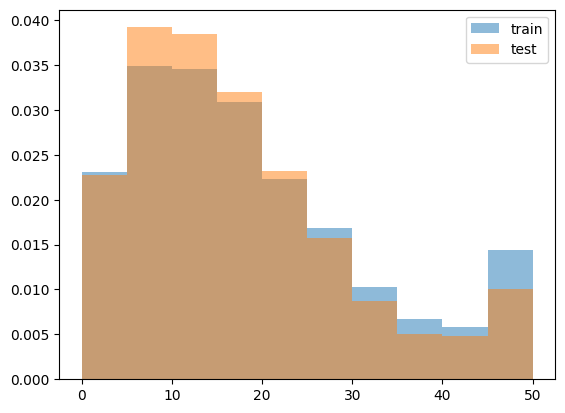

In [14]:
train_pred_df['pred_count'] = train_pred_df['yad_no'].apply(lambda d: len(d))
test_pred_df['pred_count'] = test_pred_df['yad_no'].apply(lambda d: len(d))

plt.hist(train_pred_df['pred_count'], label='train', alpha=0.5, density=True)
plt.hist(test_pred_df['pred_count'], label='test', alpha=0.5, density=True)
plt.legend()